# Import Packages

In [1]:
from packages import *
%matplotlib inline

# Matplotlib setup

In [2]:
plt.style.use('seaborn')                  
plt.rcParams['ytick.right']     = False
plt.rcParams['ytick.labelright']= False
plt.rcParams['ytick.left']      = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['figure.figsize']  = [7,7]

In [3]:
def plot(wav,rate,title):
    plt.figure(figsize=(16,6))
    plt.plot(np.linspace(0, len(wav)/rate, len(wav)), wav)
    plt.title(title)
    plt.xlabel('time in seconds')
    plt.ylabel('amplitude')
    plt.show()

# Define audio file

In [4]:
audio_dir = 'test_file'

In [5]:
flag = False #True

In [6]:
if(flag==True):
    file = 'recorded.wav'
    fs = 48000
    second = 1.5
    print("Recording...")
    record_voice = sounddevice.rec(int(second * fs), samplerate = fs, channels = 2)
    sounddevice.wait()
    write(os.path.join(audio_dir,file), fs, record_voice)
    print("Finished!! Please check your output file")
    
else:
    file = 'virufy_positive.wav'

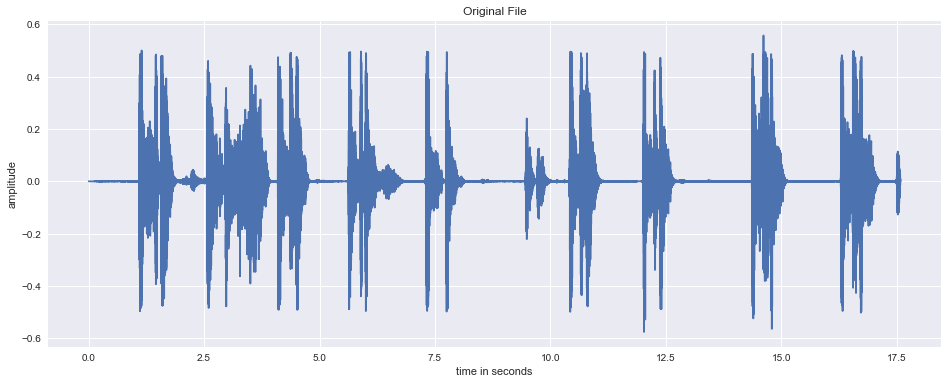

In [7]:
wav, rate = librosa.load(os.path.join(audio_dir,file),sr=16000)
title = 'Original File'
plot(wav,rate,title)

# Preprocessing

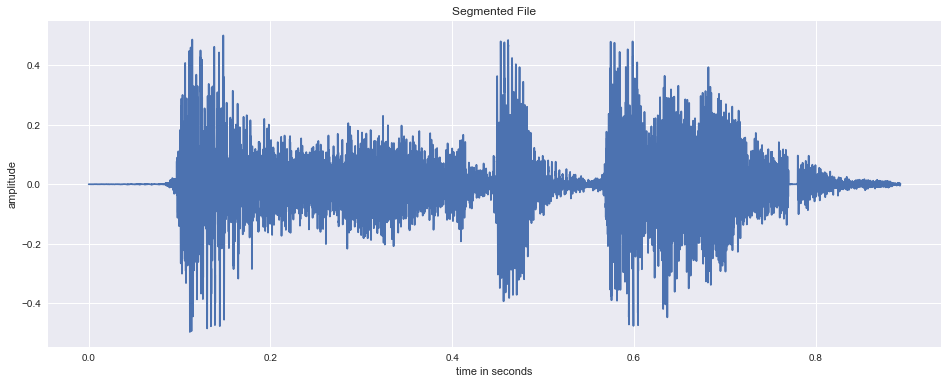

In [8]:
# Split/segment audio files using silence detection
def segment(audio_dir,fn):
    sound = AudioSegment.from_wav(os.path.join(audio_dir,fn))
    audio_chunks = split_on_silence(sound, min_silence_len=200, silence_thresh=sound.dBFS-16)
    for i, chunk in enumerate(audio_chunks):
        file = "clean{}.wav".format(i)
        chunk.export(os.path.join(audio_dir,file), format="wav")
        break
        
segment(audio_dir,file)
fn = "clean0.wav"
wav, rate = librosa.load(os.path.join(audio_dir,fn),sr=16000)
title = 'Segmented File'
plot(wav,rate,title)

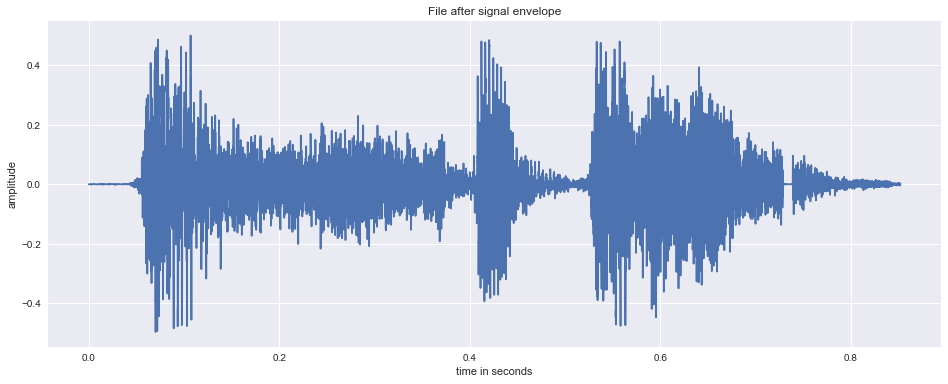

In [9]:
# Signal envelope to remove noise/silence
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

mask = envelope(wav, rate, 0.0005)
wav = wav[mask]
title = 'File after signal envelope'
plot(wav,rate,title)

# Feature Extraction & Base Learner Prediction

In [10]:
############ function to calculate the entropy value of an input signal ################
# entropy values can be taken as a measure of complexity of the signal
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    e = entropy(probabilities)
    return e

############## function to calculate some statistics ################
def calculate_statistics(list_values):
    n25 = np.nanpercentile(list_values, 25) # 25th percentile value
    median = np.nanpercentile(list_values, 50) # Median
    n75 = np.nanpercentile(list_values, 75) # 75th percentile value
    mean = np.nanmean(list_values) # Mean
    std = np.nanstd(list_values) # standard deviation
    var = np.nanvar(list_values) # variance
    return [n25, median, n75, mean, std, var]

############# function to calculate the ZCR and mean CR ############
def calculate_crossings(list_values):
    # Zero crossing rate, i.e. the number of times a signal crosses y = 0
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)>0))[0] 
    no_zero_crossings = len(zero_crossing_indices)
    
    # Mean crossing rate, i.e. the number of times a signal crosses y = mean(y)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values)>np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

############# function to combine the results of these three functions above ###########
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [11]:
def build_predictions_cnn(wav):
    
    fn_prob = {}

    # feature extraction and modeling
    y_pred = []

    for i in range(0,wav.shape[0]-config.step):
        sample = wav[i:i+config.step] # choose sample of size config.step
        x = mfcc(sample, rate,
                numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        x = (x-config.min)/(config.max-config.min)

        if config.mode == 'conv':
            x = x.reshape(1, x.shape[0], x.shape[1], 1)
        elif config.mode == 'time':
            x = np.expand_dims(x, axis=0)

        y_hat = model.predict(x)[0][0]

        y_pred.append(round(y_hat,0))

    fn_prob[fn] = int(statistics.mode(y_pred))

    return fn_prob

In [12]:
def build_predictions_lstm(wav):
    
    fn_prob = {}
      
    # feature extraction and modeling
    y_pred = []

    for i in range(0,wav.shape[0]-config.step):
        sample = wav[i:i+config.step] # choose sample of size config.step
        x = mfcc(sample, rate,
                numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        x = (x-config.min)/(config.max-config.min)

        if config.mode == 'conv':
            x = x.reshape(1, x.shape[0], x.shape[1], 1)
        elif config.mode == 'time':
            x = np.expand_dims(x, axis=0)

        y_hat = model.predict(x)[0][0]

        y_pred.append(round(y_hat,0))

    fn_prob[fn] = int(statistics.mode(y_pred))
        
    return fn_prob

In [13]:
def build_predictions_tempfour(wav):
    fn_prob = {}
            
    # feature extraction and modeling
    y_pred = []

    step=int(rate/10)

    for i in range(0,wav.shape[0]-step):

        # crop duration
        sample = wav[i:i+step]

        # feature extraction
        mt, st, mt_n = aF.mid_feature_extraction(sample, rate, 
                                             mid_window = 1 * rate, 
                                             mid_step = 1 * rate, 
                                             short_window = 0.025 * rate, 
                                             short_step = 0.010 * rate)

        # create dataframe
        x = np.transpose(mt)
        x = pd.DataFrame(x,columns=mt_n)

        # selection
        x = x[col]

        # scaling
        x = sc.transform(x)

        # prediction    
        y_hat = model.predict(x)[0]
        y_pred.append(y_hat)

    fn_prob[fn] = statistics.mode(y_pred)

    return fn_prob

In [14]:
# mfcc 2d cnn
start = time.time()
p_path = os.path.join('pickles','conv.p')
with open(p_path,'rb') as handle:
    config = pickle.load(handle)
model = load_model(config.model_path)
print('Time taken to load model:',time.time()-start,'sec')

start = time.time()
fn_prob1 = build_predictions_cnn(wav)
print(fn_prob1)
print('Time taken by model for inference:',time.time()-start,'sec')

Time taken to load model: 0.8319807052612305 sec
{'clean0.wav': 1}
Time taken by model for inference: 375.7530195713043 sec


In [15]:
# mfcc lstm
start = time.time()
p_path = os.path.join('pickles','time.p')
with open(p_path,'rb') as handle:
    config = pickle.load(handle)
model = load_model(config.model_path)
print('Time taken to load model:',time.time()-start,'sec')

start = time.time()
fn_prob2 = build_predictions_lstm(wav)
print(fn_prob2)
print('Time taken by model for inference:',time.time()-start,'sec')

Time taken to load model: 2.555514097213745 sec
{'clean0.wav': 1}
Time taken by model for inference: 363.79985785484314 sec


In [16]:
# add mfcc 2d cnn and mfcc lstm model prediction to arbitrator
arbitrator = [fn_prob1,fn_prob2]

In [17]:
# tempfour ml
for m in os.listdir('models/TempFour'):
    if('.sav' in m):
        
        print(m)
        start = time.time()
        sc = load('models/TempFour/std_scaler_TempFour.bin')
        model = pickle.load(open('models/TempFour/{}'.format(m), 'rb'))
        get_columns = pd.read_csv('data/TempFour_train_data.csv')
        col = list(get_columns.columns[:-1])
        print('Time taken to load model:',time.time()-start,'sec')

        start = time.time()
        fn_prob3 = build_predictions_tempfour(wav)
        print(fn_prob3)
        print('Time taken by model for inference:',time.time()-start,'sec')
        
        # add tempfour ml model prediction to arbitrator
        arbitrator.append(fn_prob3)
        
        print('*'*100)

GB_TempFour.sav
Time taken to load model: 0.01600360870361328 sec
{'clean0.wav': 1}
Time taken by model for inference: 90.4869294166565 sec
****************************************************************************************************
KNN_TempFour.sav
Time taken to load model: 0.00700068473815918 sec
{'clean0.wav': 1}
Time taken by model for inference: 90.91830110549927 sec
****************************************************************************************************
LR_TempFour.sav
Time taken to load model: 0.006000518798828125 sec
{'clean0.wav': 1}
Time taken by model for inference: 87.23724102973938 sec
****************************************************************************************************
NB_TempFour.sav
Time taken to load model: 0.007001638412475586 sec
{'clean0.wav': 1}
Time taken by model for inference: 87.44985818862915 sec
****************************************************************************************************
RF_TempFour.sav
Time taken to 

# Arbitrator Prediction

In [18]:
# Hard voting
result = [list(i.values())[0] for i in arbitrator]
try:
    print(statistics.mode(result))
except:
    print('tie')

1
